# Time Series

The problem addresses the prediction of a future trend from a time series. Here, we have the monthly retail debit card usage in Iceland (million ISK) from january 2000 to december 2012 and we want to predict the cumulated debit card usage during the 4 first months of 2013. Frequencies and nature of the concerned time seris alongside the choice and the validation of the model will be carefully pondered.

## Libraries importations

* numpy: using mathematical tools on matrix
* pandas: data analysis and manipulation tool
* matplotlib.pyplot: ploting graphs to represent data
* adfuller from statsmodels.tsa.stattools: performing Augmented Dickey-Fuller statistical test
* plot_acf and plot_pacf from statsmodels.graphics.tsaplots: plotting ACF and PACF
* boxcox from scipy.stats: performing Box-Cox transformation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX as sarimax
from scipy.stats import boxcox

## Time sery overview

First thing to do is to import the time series which is stored in a CSV file. Time series can be interpreted as particular datframes whose index is eventually the date of the sample. Here, we observe that the index are the begining of the month of each sample, so we set the idex frequence accordingly.

In [2]:
ts = pd.read_csv('data/debitcards.csv', index_col=0, parse_dates=True)
ts.index.freq = 'MS'
index = ts.index
ts.head()

V1
2000-01-01  7204.0
2000-02-01  7335.0
2000-03-01  7812.0
2000-04-01  7413.0
2000-05-01  9136.0

By plotting the raw time serie, it is obvious that the time serie is not stationnary and following an increasing trend.

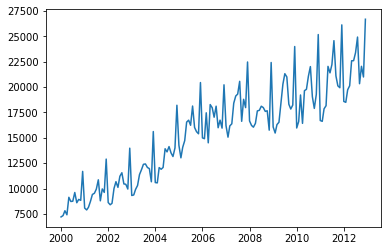

In [3]:
plt.plot(ts)
plt.show()

Graphically oberving a non-stationary property is good, asserting it with a statistical test is better. Thus, we decide to use the Augmented Dickey-Fuller statistical test that permit the rejection of the stationnary hypothesis if the computed p-value is limited (under  10−3 ). As we are likely to perform this test several times, we decide to implement a short function to simplify its usage.

In [4]:
def adf_test(ts):
    test = adfuller(ts)
    p_value = test[1]
    return p_value

In the case of the raw time sery, the Augmented Dickey-Fuller statistical test indicates that the stationnary hypothesis can be rejected with strong confidence.

In [5]:
adf_test(ts)

0.7881064417185542

We can go further in the graphical study of the time serie by decomposing it. Thus, it is possible to analyze its components one by one which makes their study easier. Here, the time serie is decomposed in its trend, its season and its residuals. The following plots confirm our initial deductions about the increasing trend. We also oberve a yearly pattern in the season plot which means that the time serie behave in the same manner each year. Finally, the residual component seems to be stationnary.

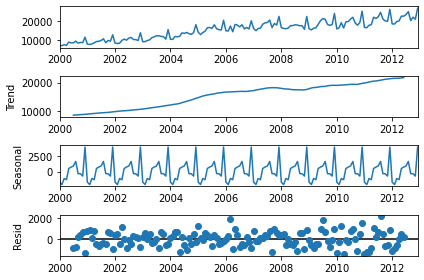

In [6]:
decomposition = seasonal_decompose(ts)
decomposition.plot()
plt.show()

We want to confirm the stationnary hypothesis of the residual component of the time series. Let's perform an Augmented Dickey-Fuller test on it. The result of the test allow us to accept the stationnary hypothesis. Thus, the residual component can be interpreted as a white noise.

In [7]:
resid = decomposition.resid
resid.dropna(inplace=True)
adf_test(decomposition.resid)

0.0001963564453499327

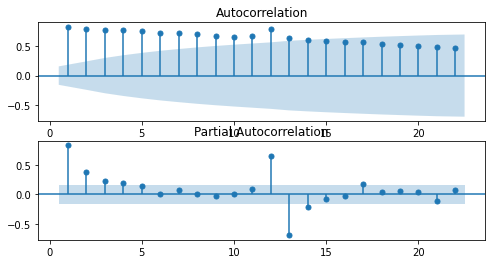

In [82]:
fig, ax = plt.subplots(2, figsize=(8,4))
plot_acf(ts, zero=False, ax=ax[0])
plot_pacf(ts, zero=False, ax=ax[1])
plt.show()

The time-series is obviously not stationnary

## Transformations

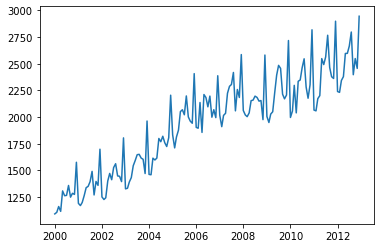

In [9]:
ts_cox = boxcox(ts.V1)[0]
ts_cox = pd.DataFrame(ts_cox, index=index)
ts_cox.index.freq = 'MS'
plt.plot(ts_cox)

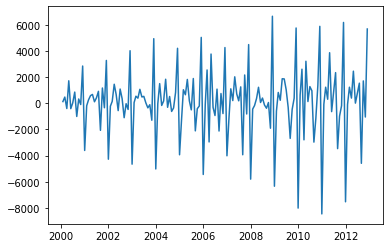

In [20]:
ts_diff = ts.diff()
ts_diff.dropna(inplace=True)
plt.plot(ts_diff)

In [21]:
adf_test(ts_diff)

0.03815703587781361

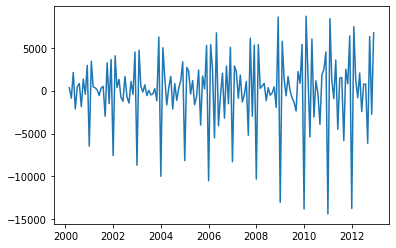

In [22]:
ts_diff2 = ts_diff.diff()
ts_diff2.dropna(inplace=True)
plt.plot(ts_diff2)

In [23]:
adf_test(ts_diff2)

1.0536657861799421e-23

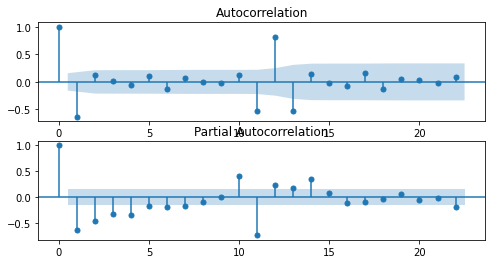

In [24]:
fig, ax = plt.subplots(2, figsize=(8,4))
plot_acf(ts_diff2, ax=ax[0])
plot_pacf(ts_diff2, ax=ax[1])
plt.show()

In [25]:
test = adfuller(ts_diff)
pvalue = test[1]
pvalue

0.03815703587781361

In [83]:
ts_train = ts[:"2006-01-01"] 
ts_test = ts["2006-01-01":]

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[]

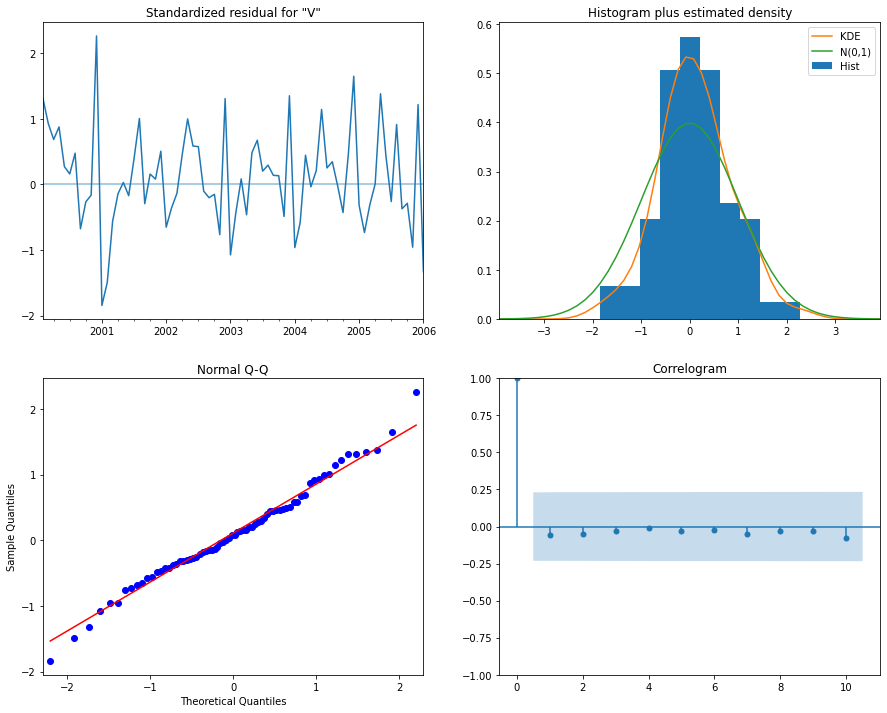

In [84]:
model = sarimax(ts_train, order=(4,1,14))
model_fit = model.fit()
model_fit.plot_diagnostics(figsize=(15, 12))
plt.plot()

[]

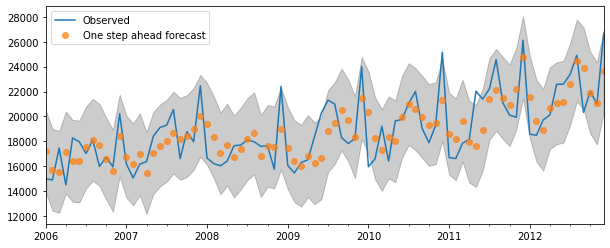

In [85]:
model_test = sarimax(ts, order=(4,1,14))
model_test_res = model_test.filter(model_fit.params)
pred = model_test_res.get_prediction(start='2006-01-01')
pred_ci = pred.conf_int()
ax = ts_test.plot(y='V1', label='Observed', figsize=(10,4))
pred.predicted_mean.plot(ax=ax, label="One step ahead forecast", alpha=0.7, linestyle='', marker='o')
ax.fill_between(pred_ci.index, pred_ci['lower V1'], pred_ci['upper V1'], color='k', alpha=0.2)
plt.legend()
plt.plot()